
## Stages 

- Data Cleaning and Prprocessing 
- Model Building 
- TF serving 

In [79]:
import tensorflow as tf 
from tensorflow.keras import models , layers 
import matplotlib.pyplot as plt

In [80]:
IMAGE_SIZE = 256 
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 50

In [81]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 2152 files belonging to 3 classes.


In [82]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [83]:
len(dataset)

135

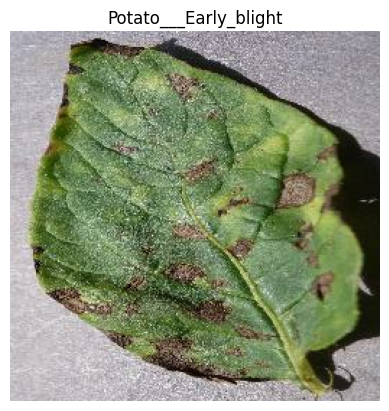

In [84]:
for image_batch , label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')
    # print(label_batch.numpy())

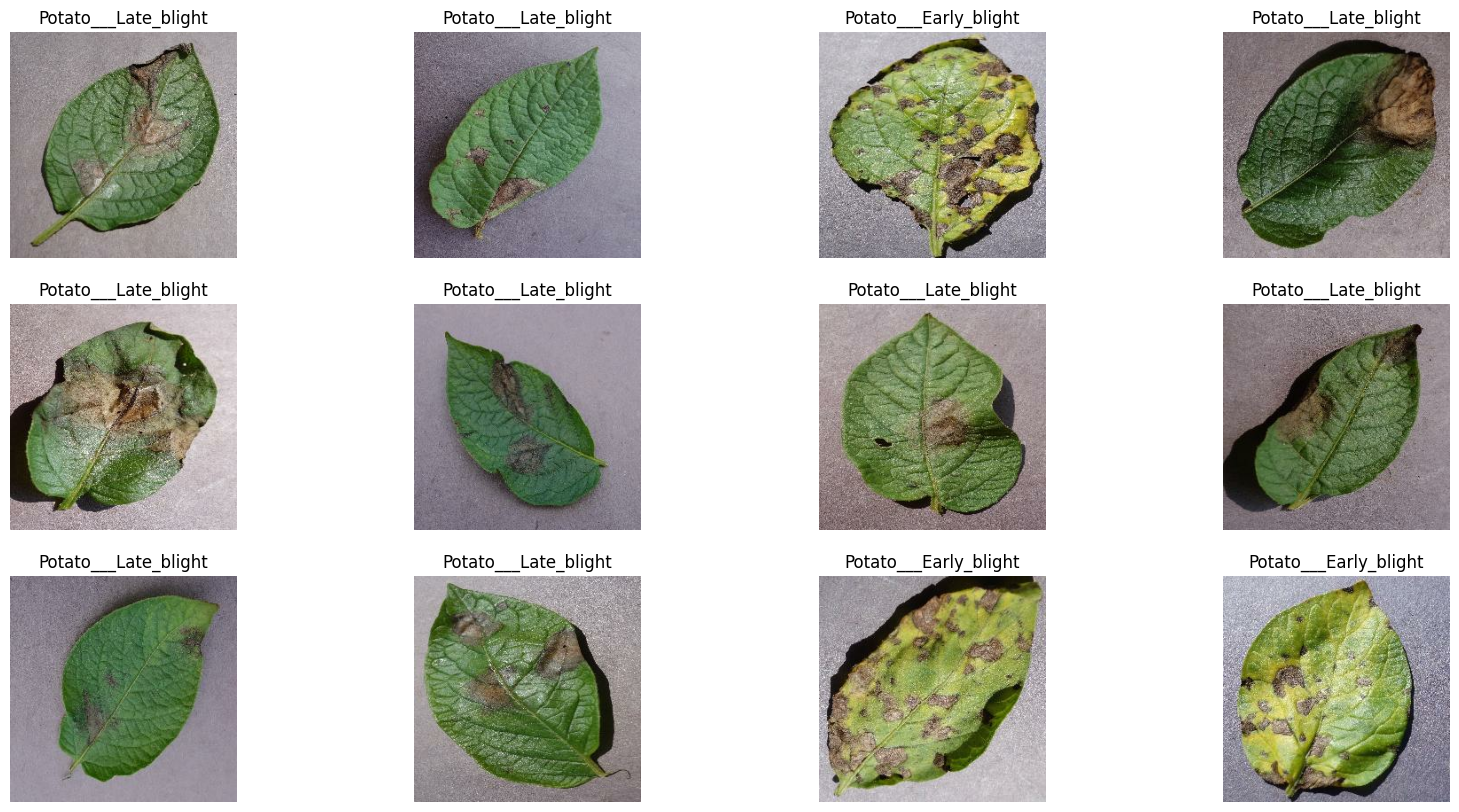

In [85]:
plt.figure(figsize=(20,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    # print(label_batch.numpy())

In [86]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [87]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [88]:
len(train_ds)

108

In [89]:
len(val_ds) , len(test_ds)


(13, 14)

In [90]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [91]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [92]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [93]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [94]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [95]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [96]:
import warnings 

warnings.filterwarnings('ignore')

In [97]:
CHANNELS
class_names
n_classes

3

In [99]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
108/108 [==============================] - 19s 176ms/step - loss: 0.0723 - accuracy: 0.9693 - val_loss: 0.0899 - val_accuracy: 0.9750
Epoch 2/50
108/108 [==============================] - 17s 155ms/step - loss: 0.0798 - accuracy: 0.9688 - val_loss: 0.1143 - val_accuracy: 0.9400
Epoch 3/50
108/108 [==============================] - 15s 139ms/step - loss: 0.0523 - accuracy: 0.9838 - val_loss: 0.0560 - val_accuracy: 0.9750
Epoch 4/50
108/108 [==============================] - 14s 132ms/step - loss: 0.0560 - accuracy: 0.9780 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 5/50
108/108 [==============================] - 12s 113ms/step - loss: 0.0669 - accuracy: 0.9757 - val_loss: 0.2138 - val_accuracy: 0.9100
Epoch 6/50
108/108 [==============================] - 12s 113ms/step - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.1576 - val_accuracy: 0.9500
Epoch 7/50
108/108 [==============================] - 13s 123ms/step - loss: 0.0479 - accuracy: 0.9844 - val_loss: 0.0846 - val_ac

In [100]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 5s 37ms/step - loss: 0.0939 - accuracy: 0.9911


In [101]:
history

In [102]:
history.params 

{'verbose': 1, 'epochs': 50, 'steps': 108}

In [103]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [104]:
max(history.history['accuracy'])

1.0

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

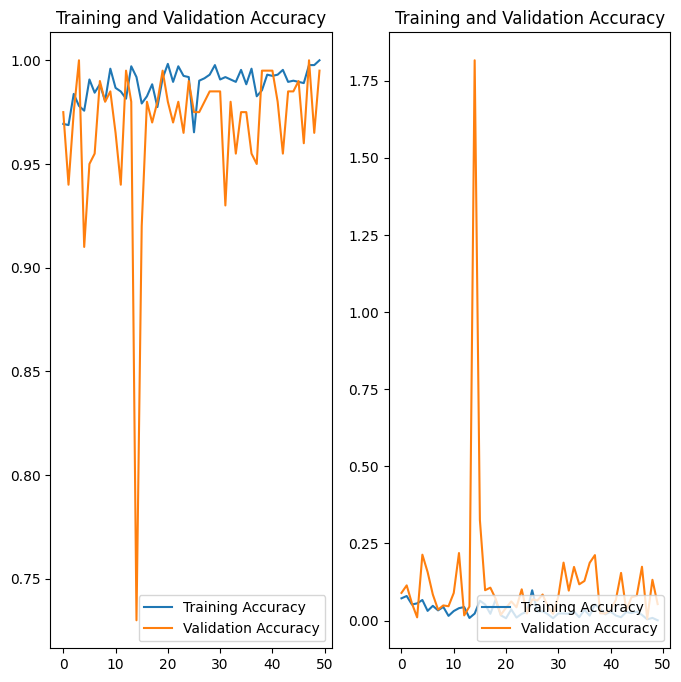

In [106]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [107]:
import numpy as np

first image to predict
first image actual label Potato___Late_blight
1/1 [==============================] - 0s 351ms/step
1
predicted label Potato___Late_blight


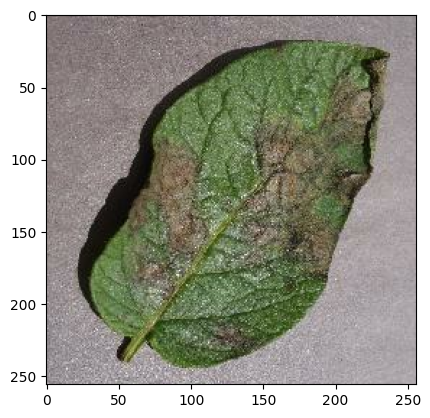

In [108]:
for images_batch , labels_batch in test_ds.take(1):
    # plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label', class_names[first_label] )

    batch_prediction = model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print('predicted label',class_names[np.argmax(batch_prediction[0])])

In [109]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence


1/1 [==============================] - 0s 19ms/step


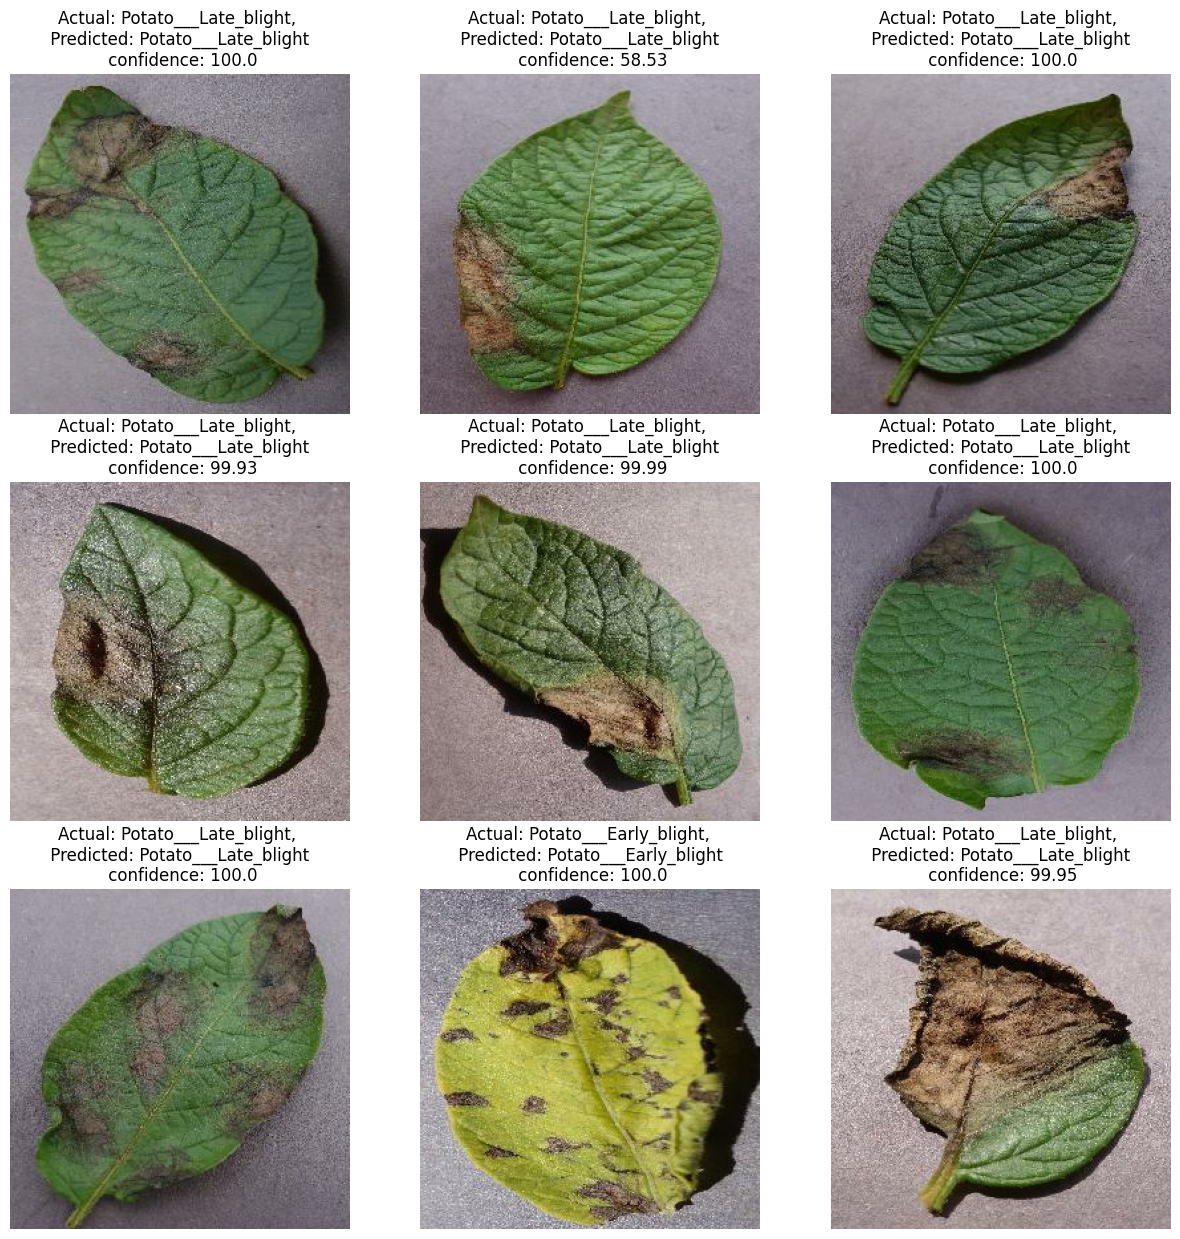

In [110]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class} \n confidence: {confidence}')
        plt.axis('off')

In [111]:
model.save('model.h5')

In [ ]:
print(tf.__version__)

2.10.1
